### Урок 7. #Интерпретация прогнозов модели (SHAP) - объясняем поведение модели на отдельных наблюдениях#

Урок 7. Интерпретация прогнозов модели (SHAP): объясняем поведение модели на отдельных наблюдениях
Домашнее задание
Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
- всего тестового набора данных (summary_plot - дать интерпретацию)
- для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

Ссылки:
- Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
- Github проекта SHAP - https://github.com/slundberg/shap
- https://arxiv.org/pdf/1809.04559.pdf
- https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
- https://en.wikipedia.org/wiki/Shapley_value

Feature selection:

RFE - recursive feature elimination (есть в sklearn)
Boruta - shadow features
Target permutation


Источник данных
https://www.kaggle.com/barun2104/telecom-churn

### SHAP

In [2]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

Датасет на таргет - отток в телекоммуникационной компании, объяснение признаков ниже (цевая переменная - churn)


AccountWeeks - 
number of weeks customer has had active account

ContractRenewal - 
1 if customer recently renewed contract, 0 if not

DataPlan - 
1 if customer has data plan, 0 if not

DataUsage - 
gigabytes of monthly data usage

CustServCalls - 
number of calls into customer service

DayMins - 
average daytime minutes per month

DayCalls - 
average number of daytime calls

MonthlyCharge - 
average monthly bill


OverageFee - 
largest overage fee in last 12 months

RoamMins - average number of roaming minutes

In [4]:
df = pd.read_csv("telecom_churn.csv")

df.head(3)

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2


In [5]:
df.columns

Index(['Churn', 'AccountWeeks', 'ContractRenewal', 'DataPlan', 'DataUsage',
       'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee',
       'RoamMins'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


In [9]:
features = ['AccountWeeks', 'ContractRenewal', 'DataPlan', 'DataUsage',
       'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee',
       'RoamMins']
target = df['Churn']

In [10]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], target, random_state=0)

In [ ]:
model = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train) # получили вектора

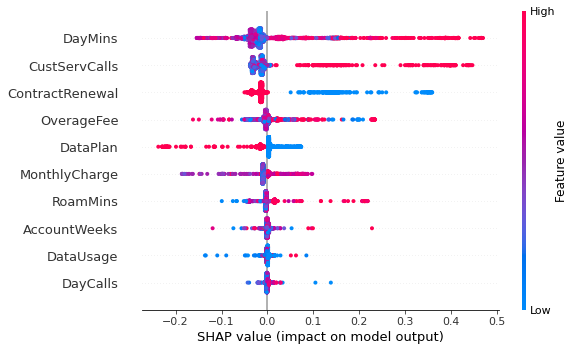

In [13]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Интерпретация summary_plot
DayMins - average daytime minutes per month
довольно сильное влияние на таргет, более склонны уйти те, то проводит много времени в сервисе, возможно,им нужно предложить безлимитные или подобные тарифы

CustServCalls - number of calls into customer service

более склонны уйте те, кто часто звонит в службу поддержки, тоже сигнал, что нужно сделать сервис более удобным и решить технические проблемы

ContractRenewal - 1 if customer recently renewed contract, 0 if not

здесь все логично, уходят те, кто не часто возобновляют контракт

OverageFee - largest overage fee in last 12 months

здесь неоднозначно все, нужно дополнительно смотреть, но немного больше уходят те, кто меньше платит

DataPlan - 1 if customer has data plan, 0 if not

уходят те, у кого нет data plan

MonthlyCharge - average monthly bill

более склонны к оттоку те, у кого выше счета

RoamMins - average number of roaming minutes

более склонны уйте те, у кого много минут в роуминге(!)


AccountWeeks - number of weeks customer has had active account
немного более склонны уйти те, у кого больше этот показатель


DataUsage - gigabytes of monthly data usage

немного более склонны уйти те, у кого больше этот показатель


DayCalls - average number of daytime calls

неоднозначный признак, нужно его отдельно смотреть, немного больше склонны к оттоку те, у кого низкий этот показатель.

В целом можно сделать вывод, что особенное внимание нужно обратить на клиентов, которые активно пользуются сервисом и им нужно предлагать какие-то дополнительные интересные продукты



Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


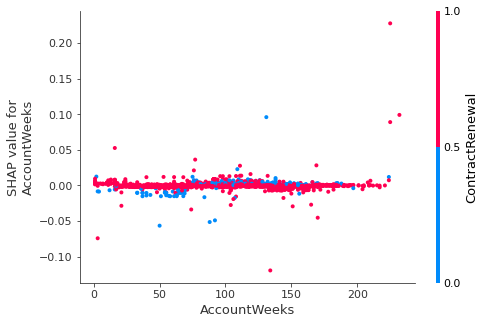

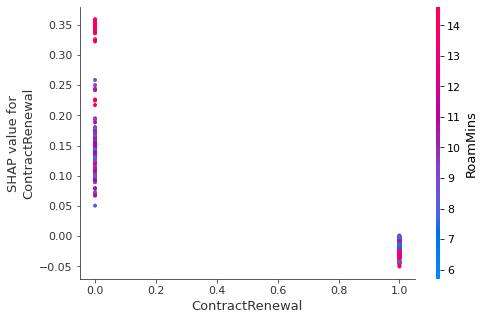

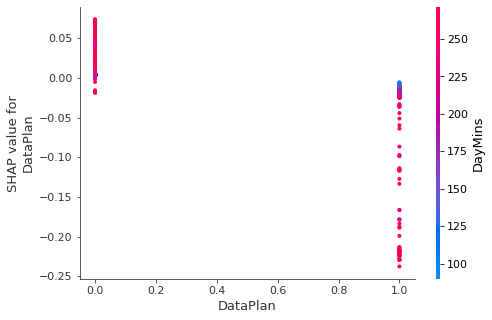

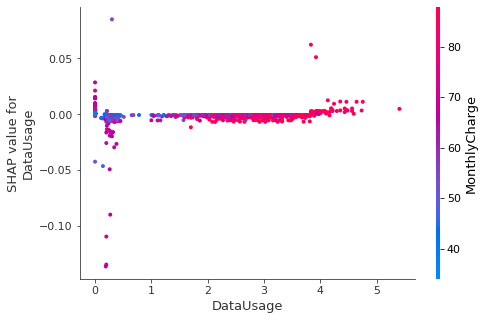

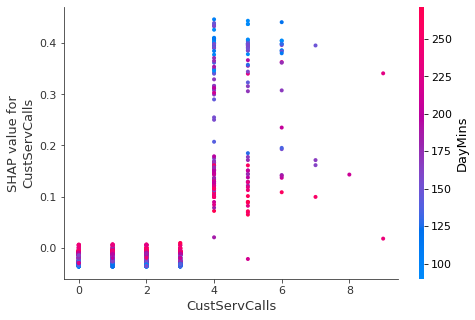

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


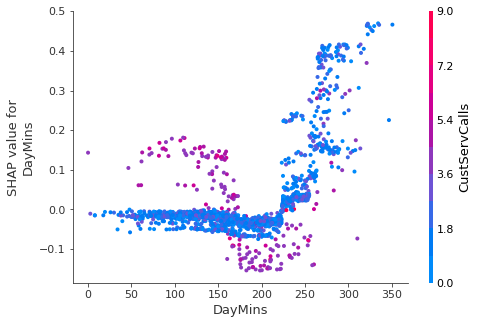

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


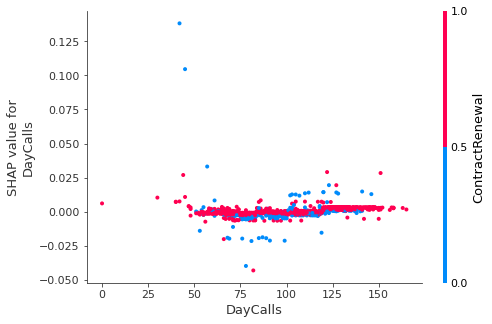

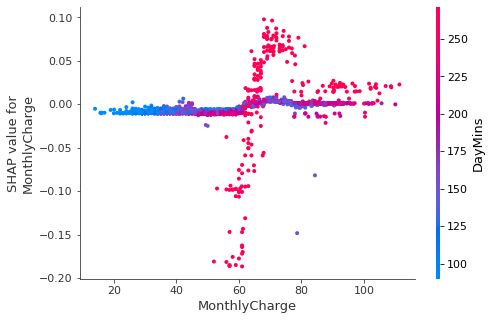

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


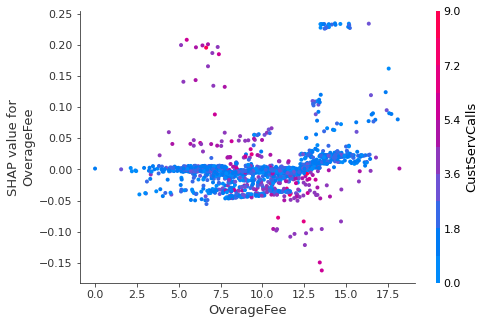

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


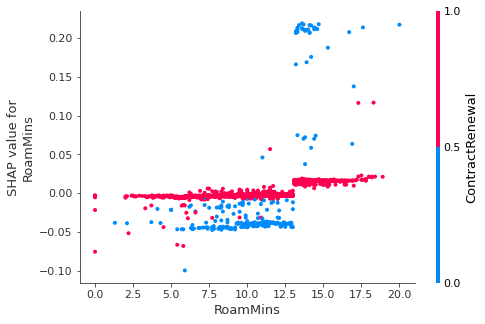

In [23]:
#shap.dependence_plot("DayCalls", shap_values, X_train)

#посмотрим отдельно признаки (их немного, можно все посмотреть, а не 10 процентов)
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train)

Можно просто взять средние значения SHAP для каждого признака

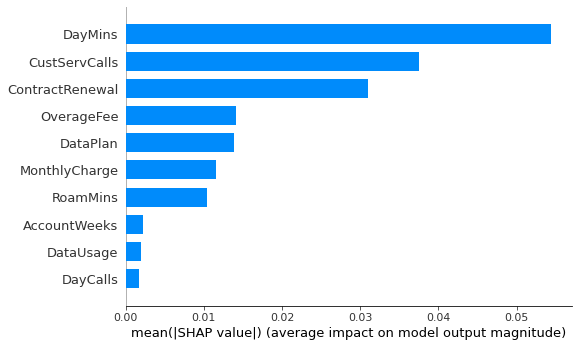

In [14]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [24]:
# для отдельных наблюдений выведем force_plot

In [25]:
shap.force_plot(explainer.expected_value, shap_values[10,:], X_train.iloc[10,:])

In [ ]:
# снижают вероятность ухода данного человека: голубые виляют на то, чтобы остался, красные: повышают вероятность ухода
то есть отсутствие  data plan, высокое DayMins и высокие минуты в роуминге RoamMins - повышают вероятность оттока
а возобновление контракта, низкая стоимость fee и помесячной оплаты - увеличивают шанс остаться

In [31]:
shap.force_plot(explainer.expected_value, shap_values[955,:], X_train.iloc[955,:])

In [ ]:
# этот человек уйдет скорее всего, так как у него все основные признаки с красной зоне: большое кол-во Daymins, не возобновляется контракт,
# высокая месячная оплата, отсутствует data plan.

# в общем, совершенно точно нужно добавлять тарифные планы для постоянных клиентов, иначе они уйдут

In [28]:
shap.force_plot(explainer.expected_value, shap_values[670,:], X_train.iloc[670,:])

In [ ]:
#здесь высокая вероятность оттока, так как не возобновляется контракт